In [0]:
'''
P2P

with normalisation
no dropout
'''

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'drive/My Drive/Dissertation')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
pip install git+git://github.com/nilmtk/nilmtk.git

  Cloning git://github.com/nilmtk/nilmtk.git to /tmp/pip-req-build-5xfhug0_
  Running command git clone -q git://github.com/nilmtk/nilmtk.git /tmp/pip-req-build-5xfhug0_
     |████████████████████████████████| 2.9MB 45.0MB/s 
     |████████████████████████████████| 1.6MB 45.3MB/s 
     |████████████████████████████████| 153kB 50.6MB/s 
     |████████████████████████████████| 337kB 48.4MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-_ha9_sei/wheels/71/84/2f/eca0fb8014a0fe59881ab1a3e3374f4108211de4c7c3081e8d
  Stored in directory: /root/.cache/pip/wheels/44/c0/34/6f98693a554301bdb405f8d65d95bbcd3e50180cbfdd98a94e
  Stored in directory: /root/.cache/pip/wheels/2c/b6/0e/63a865a30e21e01d04f417d8995fbfb793d6bd464707efc546
Successfully built nilmtk networkx hmmlearn
ERROR: ipython 5.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.4, but you'll have prompt-toolkit 2.0.9 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9

In [3]:
pip install git+git://github.com/nilmtk/nilm_metadata.git

  Cloning git://github.com/nilmtk/nilm_metadata.git to /tmp/pip-req-build-l4xbo4j8
  Running command git clone -q git://github.com/nilmtk/nilm_metadata.git /tmp/pip-req-build-l4xbo4j8
  Stored in directory: /tmp/pip-ephem-wheel-cache-zrm443bm/wheels/75/e0/6d/1ec555a322c151fe20b4c9834753a692203b1f62a66b3ee235
Successfully built nilm-metadata


In [4]:
pip install pandas==0.24.0

     |████████████████████████████████| 10.1MB 37.7MB/s 
ERROR: nilmtk 0.3.0.dev0+git.2f15ab7 has requirement pandas==0.24.2, but you'll have pandas 0.24.0 which is incompatible.
  Found existing installation: pandas 0.24.2
    Uninstalling pandas-0.24.2:
      Successfully uninstalled pandas-0.24.2


In [0]:
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore


import random
import sys
import pandas as pd
import numpy as np
import h5py


In [0]:
# =====Define paramaters======
info = {'filename': 'drive/My Drive/Dissertation/redd.h5',
        'meter_label': 'fridge',  # ["kettle" , "microwave" , "dishwasher" , "fridge" , "washing_machine"]
        'train_building': 1,
        'test_building': 1,
        'sample_period': 3
       }

# Parameters
params = {'batch_size': 128,
          'window_size': 50,
          'model_name': 'DAE',
          'shuffle': True}



#test_window = {1: ('30-4-2011', '5-5-2011')}
train_window = {1: (None, '25-4-2011')}
test_window = {1: ('30-4-2011', None)}


def load_dataset(train_window,test_window, filename, meter_label, train_building, test_building, **load_kwargs):
    
        #Load datasets
    train = DataSet(filename)
    test = DataSet(filename)

    test.set_window(*test_window[test_building])
    train.set_window(*train_window[test_building])
    
    x = train.buildings[train_building].elec.mains().all_meters()[0]
    x = x.power_series_all_data(**load_kwargs)
    
    y = train.buildings[train_building].elec.submeters()[meter_label]
    y = y.power_series_all_data(**load_kwargs)
    
    x.fillna(0, inplace=True)
    y.fillna(0, inplace=True)
    ix = x.index.intersection(y.index)
    x = np.array(x[ix])
    y = np.array(y[ix])
    
    #TEST
    
    x_test = test.buildings[test_building].elec.mains().all_meters()[0]
    x_test = x_test.power_series_all_data(**load_kwargs)
    
    y_test = test.buildings[test_building].elec.submeters()[meter_label]
    y_test = y_test.power_series_all_data(**load_kwargs)
    
    x_test.fillna(0, inplace=True)
    y_test.fillna(0, inplace=True)
    ix = x_test.index.intersection(y_test.index)
    x_test = np.array(x_test[ix])
    y_test = np.array(y_test[ix])

    return x ,y,x_test,y_test 
  
  
x , y, x_test, y_test =load_dataset(train_window,test_window, **info)  



### Nomralise Data

In [0]:
def normalise(data,mmax):
    return data/mmax

def inversenormalise(data,mmax):
    return data*mmax


mmax = np.max(x)
x = normalise(x,mmax)
y = normalise(y,mmax)

## Windows


In [0]:
indexer = np.arange(params['window_size'])[None, :] + np.arange(len(x)-params['window_size']+1)[:, None]
x = x[indexer]
y = y[params['window_size']-1:]

x = np.reshape(x, (x.shape[0],params['window_size'],1))
y = np.reshape(y, (y.shape[0],1))

# GRU

## Batch generator again

In [0]:
def generator(inputs, targets,batch_size=128,window=50):
        
        num_of_steps = int((len(inputs)-window+1) / batch_size)# - 1
        indexes=list(range(num_of_steps))
        
#         np.random.shuffle(indexes)
        
        
        while True:
            for ei, e in enumerate(indexes):
              offset = e * batch_size

              mainpart = inputs
              meterpart = targets
              mainpart = np.array(mainpart)
              indexer = np.arange(window)[None, :] + np.arange(len(mainpart)-window+1)[offset:offset + batch_size, None]

              mainpart = mainpart[indexer]
              meterpart = meterpart[window - 1:][offset:offset + batch_size]

              X = np.reshape(mainpart, (batch_size, window, 1))
              Y = np.reshape(meterpart, (batch_size, 1))

              yield X,Y



In [23]:
import random
import sys
import pandas as pd
import numpy as np
import h5py

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Conv1D, GRU, Bidirectional, Dropout


model = Sequential()

# 1D Conv
model.add(Conv1D(16, 4, activation="relu", padding="same", strides=1, input_shape=(params['window_size'],1)))
model.add(Conv1D(8, 4, activation="relu", padding="same", strides=1))

# Bi-directional LSTMs
model.add(Bidirectional(GRU(64, return_sequences=True, stateful=False), merge_mode='concat'))
model.add(Bidirectional(GRU(128, return_sequences=False, stateful=False), merge_mode='concat'))

# Fully Connected Layers
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam')

model.fit_generator(generator(x, y), 
                    steps_per_epoch =  int((len(x)-50+1) / 128) - 1, 
                    epochs=8)

Epoch 1/8
1485/1485 [==============================] - 379s 256ms/step - loss: 3470.0337
Epoch 2/8
1485/1485 [==============================] - 375s 253ms/step - loss: 2730.0873
Epoch 3/8
1485/1485 [==============================] - 371s 250ms/step - loss: 2714.1495
Epoch 4/8
1485/1485 [==============================] - 365s 246ms/step - loss: 2489.5168
Epoch 5/8
1485/1485 [==============================] - 359s 242ms/step - loss: 2641.8559
Epoch 6/8
1485/1485 [==============================] - 359s 242ms/step - loss: 2806.9155
Epoch 7/8
1485/1485 [==============================] - 360s 242ms/step - loss: 2567.0006
Epoch 8/8
1485/1485 [==============================] - 359s 241ms/step - loss: 2191.5332


In [0]:
indexer = np.arange(50)[None, :] + np.arange(len(x)-50+1)[:, None]
x1 = x[indexer]
y1 = y[50-1:]

x1 = np.reshape(x1, (x1.shape[0],50,1))

predict = model.predict(x1, batch_size=128)

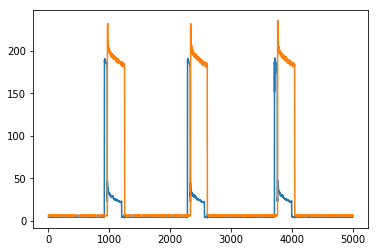

In [26]:
plt.plot(predict[60000:65000])
plt.plot(y[60000:65000])

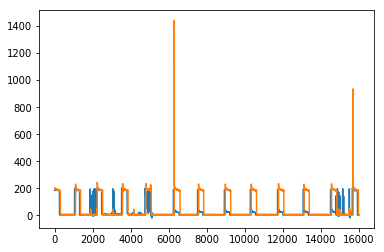

In [29]:
plt.plot(predict[52000:68000])
plt.plot(y[52000:68000])

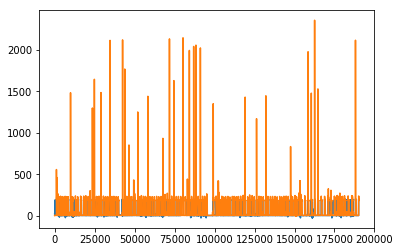

In [28]:
plt.plot(predict)
plt.plot(y)